# SNS Junctions Josephson effect

This notebook contains the code to calculate transport properties of SNS junctions using a Green's function approach.

The calculation starts by constructing a microscopic Hamiltonian for a $N_{\text{lat}} \times N_{\text{lat}} \times N_z$ device. The Hamiltonian is constructed under the tight-binding model with only nearest neighbour interactions.

In order to incorportate superconductivity in the calculations, BdG form of the Hamiltonian matrix elements is used. The Hamiltonian is described by two parameters $\alpha$ and $\beta$.

Generally,
\begin{align*}
    \alpha &= \begin{pmatrix} 2t & \Delta \\ \Delta* & -2t \end{pmatrix} \\
    \beta &= \begin{pmatrix} t & 0 \\ 0 & -t \end{pmatrix}
\end{align*}
where $t$ is controlled by the lattice spacing and is equal to the hopping energy and $\Delta$ is the superconducting pairing potential.

One can think of the two indices in the BdG matrix elements as corresponding to up spin electrons and down spin holes. Superconductivity is induced by a pairing between these two populations to form composite Cooper pairs.

In [11]:
# Trying out the functional calculation of the Hamiltonian

import numpy as np
import itertools
import scipy.special


def create_Hamiltonian(dimensions,physical_parameters):
    '''
    dimensions : dictionary with the following three numbers,
        N_lat : number of points laterally
        N_z : number of points in the z direction
        N_int : number of internal degrees of freedom = 1,2,4
    physical_paramters : dictionary with the revelant physical parameters
    '''
    N_lat = dimensions['N_lat']
    N_z = dimensions['N_z']
    N_int = dimensions['N_int']
    
    t = physical_parameters['t']
    Delta = physical_parameters['Delta']
    
    # Hamiltonian element functions
    def create_alpha(ind):
        if N_int == 1:
            alpha = 2*t
        elif N_int == 2:
            alpha = np.array([[2*t,Delta],[np.conj(Delta),-2*t]])
        
        return alpha

    def create_beta(ind1,ind2):
        if N_int == 1:
            beta = -t
        elif N_int == 2:
            beta = np.array([[t,0],[0,-t]])
    
        return beta

    def create_zero():
        if N_int == 1:
            return 0.0
        elif N_int == 2:
            return np.zeros((2,2))
    
    def func_H(ind1,ind2):
        if ind1 == ind2:
            return create_alpha(ind1)
        elif tuple(abs(x) for x in tuple(i-j for i,j in zip(ind1,ind2))) \
        in [(0,0,1),(0,1,0),(1,0,0)]:
            return create_beta(ind1,ind2)
        else:
            return create_zero()

    # list of space indices of the Hamiltonian    
    indices = list(itertools.product(range(N_lat),range(N_lat),range(N_z)))
    H = [func_H(ind1,ind2) for ind1,ind2 in itertools.product(indices, indices)]

    N = N_lat*N_lat*N_z

    H_ar = np.array(H,dtype=np.complex64).reshape((N,N,N_int,N_int))
    H_mat = np.array([H_ar[x,:,y,:].flatten() for x in range(H_ar.shape[0]) for y in range(H_ar.shape[2])])\
    .flatten().reshape(N_int*N,N_int*N)

    return H_mat

def current_E(E,dimensions, physics):
    # dimensions
    N_lat = dimensions['N_lat']
    N_z =  dimensions['N_z']
    N_int = dimensions['N_int']
  
    # create the physical paramters dictionaries to create the respective Hamiltonians for S1-N-S2
    physical_parameters_N = {'t' : physics['t'],'Delta' : 0.0}
    physical_parameters_S_1 = {'t' : physics['t'],'Delta' : physics['Delta_1']}
    physical_parameters_S_2 = {'t' : physics['t'],'Delta' : physics['Delta_2']}
    
    # create the local variables
    eta = physics['eta']
    kT = physics['kT']
    mu_1 = physics['mu_1']
    mu_2 = physics['mu_2']
    
    
    
    def surface_g(E,physical_parameters):
        # create a dummy Hamiltonian with two layers to get the hopping element beta and the layer element alpha
        
        dummy_dimensions = dimensions.copy()
        dummy_dimensions['N_z'] = 2
        
        H_mat = create_Hamiltonian(dummy_dimensions,physical_parameters)

        N_dof_lat = N_lat*N_lat*N_int

        alpha = H_mat[:N_dof_lat,:N_dof_lat]
        beta = H_mat[:N_dof_lat,N_dof_lat:2*N_dof_lat]

        err = 1.0
        iter_count = 0
        iter_limit = 50000
        err_limit = 1e-4

        g = np.eye(alpha.shape[0],dtype=np.complex64)
        g_old = np.eye(alpha.shape[0],dtype=np.complex64)
        # iterate over iter_limit iterations or until err < err_limit
        for i in range(iter_limit):
            g = np.linalg.inv((E + 1j*eta)*np.eye(alpha.shape[0]) - alpha - np.dot(np.dot(beta,g),beta))
            g = 0.5*(g + g_old)

            err = np.linalg.norm(g-g_old)/np.sqrt(np.linalg.norm(g)*np.linalg.norm(g_old))
            g_old = g
            if(err < err_limit):
                #print("Finished at",i,"Error :",err)
                break;
            if(i == (iter_limit - 1)):
                print("iter_limit hit in calculation of surface_g",err)
        return g
    
    g_1 = surface_g(E,physical_parameters_S_1)
    g_2 = surface_g(E,physical_parameters_S_2)
    
    H_mat = create_Hamiltonian(dimensions,physical_parameters_N)
    
    #number of dof in a layer
    N_dof_lat = N_lat*N_lat*N_int
    # the hopping element between layers
    beta_layer = H_mat[:N_dof_lat,N_dof_lat:2*N_dof_lat]
    
    # the only non-zero elements in sigma
    sigma_mini_1 = np.dot(np.dot(beta_layer,g_1),beta_layer)
    sigma_mini_2 = np.dot(np.dot(beta_layer,g_2),beta_layer)
    
    sigma_1 = np.zeros(H_mat.shape,dtype=np.complex64)
    sigma_1[:N_dof_lat,:N_dof_lat] = sigma_mini_1
    gamma_1 = 1j*(sigma_1 - np.conj(sigma_1).T)
    
    sigma_2 = np.zeros(H_mat.shape,dtype=np.complex64)
    sigma_2[-N_dof_lat:,-N_dof_lat:] = sigma_mini_2
    gamma_2 = 1j*(sigma_2 - np.conj(sigma_2).T)    
    
    def fermi(E,kT):
        return scipy.special.expit(-E/kT)
    
    def generate_fermi_matrix(E,mu,kT,N_int):
        if N_int == 1:
            return fermi(E-mu,kT)
        elif N_int == 2:
            return np.array([[fermi(E - mu,kT),0],[0,1 - fermi(E + mu,kT)]])
        
    F1 = np.kron(np.eye(N_lat*N_lat*N_z),generate_fermi_matrix(E,mu_1,kT,N_int))
    F2 = np.kron(np.eye(N_lat*N_lat*N_z),generate_fermi_matrix(E,mu_2,kT,N_int))
    
    sigma_in = np.dot(gamma_1,F1) + np.dot(gamma_2,F2)

    G = np.linalg.inv((E + 1j*eta)*np.eye(H_mat.shape[0]) - H_mat - sigma_1 - sigma_2)
    
    A = 1j*(G - np.conj(G).T)
    
    G_n = np.dot(np.dot(G,sigma_in),np.conj(G).T)
    rho = np.trace(G_n)
    
    I_mat = np.dot(G_n[:N_dof_lat,N_dof_lat:2*N_dof_lat],beta_layer) \
            - np.dot(G_n[N_dof_lat:2*N_dof_lat,:N_dof_lat],beta_layer)
    #I_mat = np.dot(gamma_1,np.dot(np.conj(G).T,np.dot(gamma_2,G))) 
    #I = np.trace(np.dot(I_mat,F1-F2))
    I = np.real(np.trace(I_mat[0::2,0::2]) - np.trace(I_mat[1::2,1::2]))

    return I,rho

/usr/local/lib/python3.5/site-packages/scipy/integrate/quadpack.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


Time 176.8113021850586


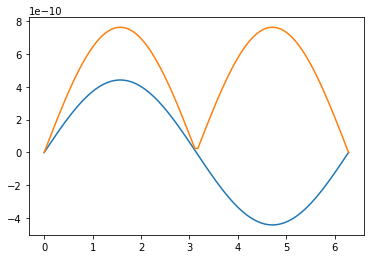

In [26]:
# Actual numerical simulation

def I_phase(phi):
    dimensions = {'N_lat' : 1,
                  'N_z'   : 5,
                  'N_int' : 2
    }

    physics = {'eta'     : 1e-8,
               't'       : 1,
               'mu_1'    : 1,
               'mu_2'    : 1,
               'Delta_1' : 0.5e-3,            
               'Delta_2' : 0.5e-3*np.exp(1j*phi),            
               'kT'      : 1e-2
    }


    #E_linspace = np.linspace(-4,4,100)
    #I_E = [current_E(E,dimensions,physics)[0] for E in E_linspace]

    #I = np.sum(np.array(I_E))
    
    import scipy.integrate
    t = physics['t']
    I = scipy.integrate.quad(lambda x: current_E(x,dimensions,physics)[0],-4*t,4*t)
    return I

phase_vec = np.linspace(0,2*np.pi,100)
import time
st = time.time()
I_vec = np.array([I_phase(x) for x in phase_vec])
print("Time",time.time()-st)

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(phase_vec,I_vec)



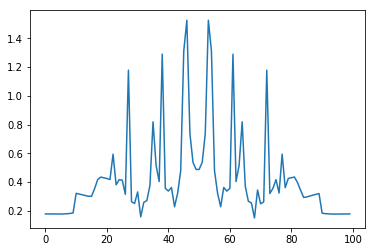

In [23]:
plt.plot(I_vec[:,1])